폰트 설치 1

In [22]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

폰트 설치 2

In [23]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
plt.rc('font', family=fm.FontProperties(fname=font_path).get_name())

데이터 불러오기

In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

df_stats = pd.read_csv('nfl_team_stats.csv')

불필요한 문자열 제거후 팀 이름만 남기기

In [37]:
df_stats['Team'] = df_stats['Team'].str.replace(r'\s+[\w\s]+$', '', regex=True)
df_stats = df_stats.set_index('Team')

key_cols = ['Att', 'Pass Yds', 'TD', 'INT']
df_analysis = df_stats[key_cols].copy()

for col in df_analysis.columns:
    df_analysis[col] = (df_analysis[col]
                        .astype(str)
                        .str.replace('T', '')
                        .replace('--', np.nan)
                        .astype(float))
df_analysis = df_analysis.fillna(df_analysis.mean())
print(df_analysis.head())

            Att  Pass Yds    TD  INT
Team                                
Browns    249.0    1245.0   5.0  6.0
49ers     241.0    1838.0  10.0  7.0
Cowboys   234.0    1658.0  13.0  4.0
Chargers  220.0    1537.0  10.0  4.0
Chiefs    213.0    1514.0  11.0  2.0


공격력 순위 분석하기

In [39]:
df_rank = df_analysis.sort_values(by='Pass Yds', ascending=False)
df_rank_1 = df_rank[['Pass Yds', 'TD']].rename(columns={
    'Pass Yds': '총 패스 야드',
    'TD': '패스 터치다운 수'
})

print(df_rank_1.head(10))

if 'Jaguars' in df_rank.index:
    jax_rank = df_rank.index.get_loc('Jaguars') + 1
    jax_yds = df_rank.loc['Jaguars']['Pass Yds']
    print(f"\n잭슨빌(Jaguars)은 총 {len(df_rank)}개 팀 중 {jax_rank}위 입니다.")
    print(f"총 패스 야드: {jax_yds:.0f} 야드")

            총 패스 야드  패스 터치다운 수
Team                          
49ers        1838.0       10.0
Rams         1684.0       12.0
Cowboys      1658.0       13.0
Seahawks     1556.0       11.0
Buccaneers   1539.0       12.0
Chargers     1537.0       10.0
Patriots     1522.0       10.0
Chiefs       1514.0       11.0
Colts        1511.0        8.0
Bills        1429.0       11.0

잭슨빌(Jaguars)은 총 32개 팀 중 13위 입니다.
총 패스 야드: 1324 야드


팀별 공격력 시각화 하기

/tmp/ipython-input-525662632.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data.index, y='Pass Yds', data=plot_data, palette=colors)
/tmp/ipython-input-525662632.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data.index, y='TD', data=plot_data, palette=colors)


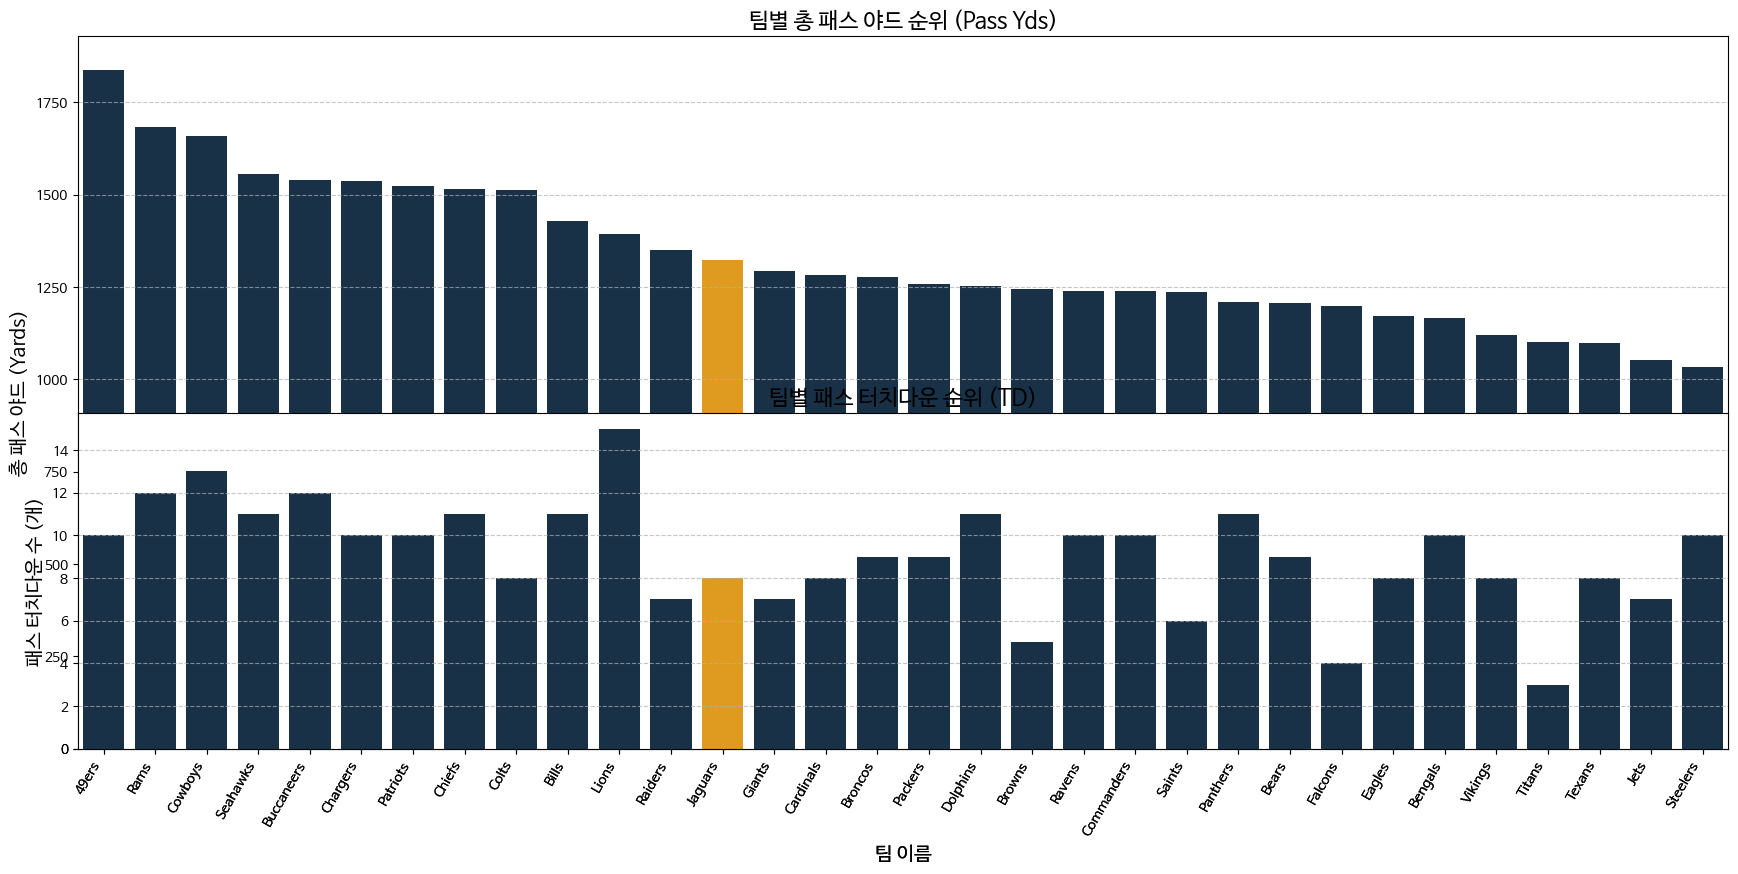

In [41]:
plot_data = df_rank.sort_values(by='Pass Yds', ascending=False)
colors = ['#FFA300' if team == 'Jaguars' else '#11324D' for team in plot_data.index]

plt.figure(figsize=(18, 10))

sns.barplot(x=plot_data.index, y='Pass Yds', data=plot_data, palette=colors)
plt.title('팀별 총 패스 야드 순위 (Pass Yds)', fontsize=16)
plt.xlabel('팀 이름', fontsize=14)
plt.ylabel('총 패스 야드 (Yards)', fontsize=14)
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
sns.barplot(x=plot_data.index, y='TD', data=plot_data, palette=colors)
plt.title('팀별 패스 터치다운 순위 (TD)', fontsize=16)
plt.xlabel('팀 이름', fontsize=14)
plt.ylabel('패스 터치다운 수 (개)', fontsize=14)
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

선형 회귀로 학습 및 평가

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

X = df_analysis[['Pass Yds']]
y = df_analysis['TD']

GAMES_PER_SEASON = 17
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"모델의 RMSE (오차 지표): {rmse:.2f} TD (시즌 총합 기준)")

모델의 RMSE (오차 지표): 2.11 TD (시즌 총합 기준)


예측하기

In [50]:
predicted_total_tds = model.predict(df_analysis[['Pass Yds']])
predicted_td_per_game = predicted_total_tds / GAMES_PER_SEASON
predicted_score_per_game = predicted_td_per_game * 7

df_prediction1 = pd.DataFrame({
    '총 패스 야드': df_analysis['Pass Yds'],
    '예측 경기당 패스 TD': predicted_td_per_game.round(2),
    '예상 실점 (경기당)': predicted_score_per_game.round(1)
}, index=df_analysis.index)

df_pred_rank_corrected = df_prediction1.sort_values(by='예상 실점 (경기당)', ascending=False)

print("\n2026 시즌 잭슨빌 상대 예상 경기당 실점 순위 (상위 10개 팀)")
print(df_pred_rank_corrected.head(10))

print("\n잭슨빌 상대 예상 경기당 실점 평균: ", df_pred_rank_corrected['예상 실점 (경기당)'].mean().round(1),"점")


2026 시즌 잭슨빌 상대 예상 경기당 실점 순위 (상위 10개 팀)
            총 패스 야드  예측 경기당 패스 TD  예상 실점 (경기당)
Team                                          
49ers        1838.0          0.74          5.2
Rams         1684.0          0.68          4.8
Cowboys      1658.0          0.67          4.7
Chargers     1537.0          0.63          4.4
Buccaneers   1539.0          0.63          4.4
Seahawks     1556.0          0.63          4.4
Colts        1511.0          0.62          4.3
Chiefs       1514.0          0.62          4.3
Patriots     1522.0          0.62          4.3
Bills        1429.0          0.58          4.1

잭슨빌 상대 예상 경기당 실점 평균:  3.8 점


결과 시각화

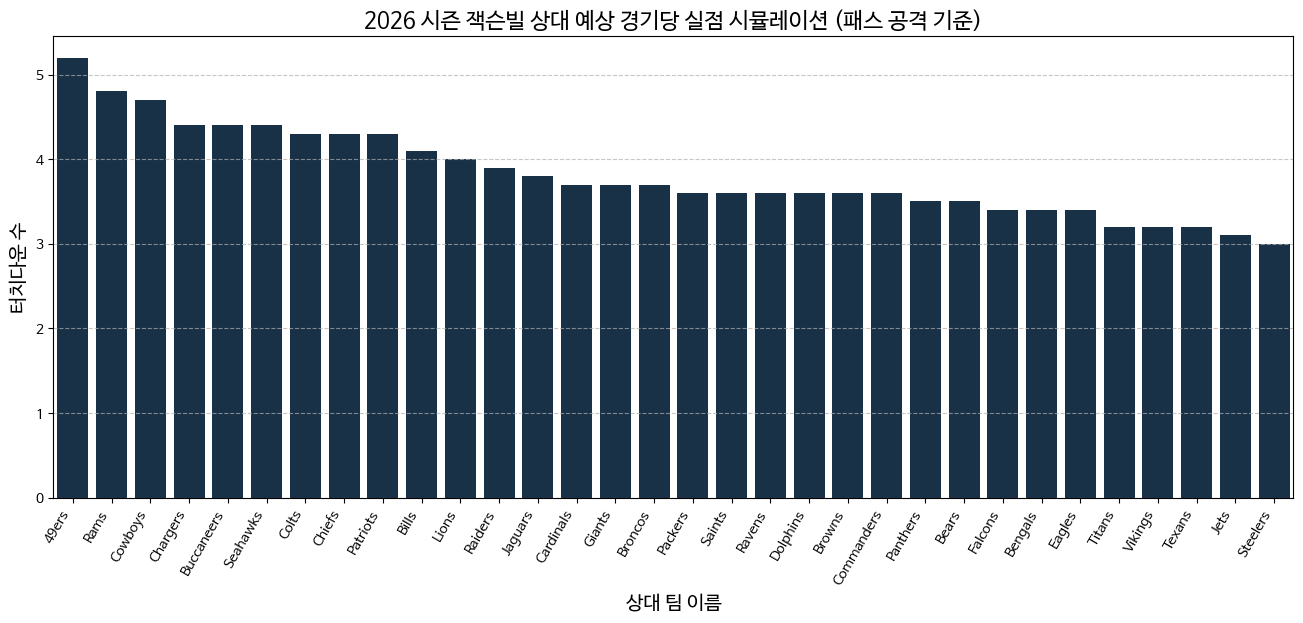

In [51]:
plot_data = df_pred_rank_corrected.sort_values(by='예상 실점 (경기당)', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(x=plot_data.index, y='예상 실점 (경기당)', data=plot_data, color='#11324D')

plt.title('2026 시즌 잭슨빌 상대 예상 경기당 실점 시뮬레이션 (패스 공격 기준)', fontsize=16)
plt.xlabel('상대 팀 이름', fontsize=14)
plt.ylabel('터치다운 수', fontsize=14)
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

히스토그램 시각화

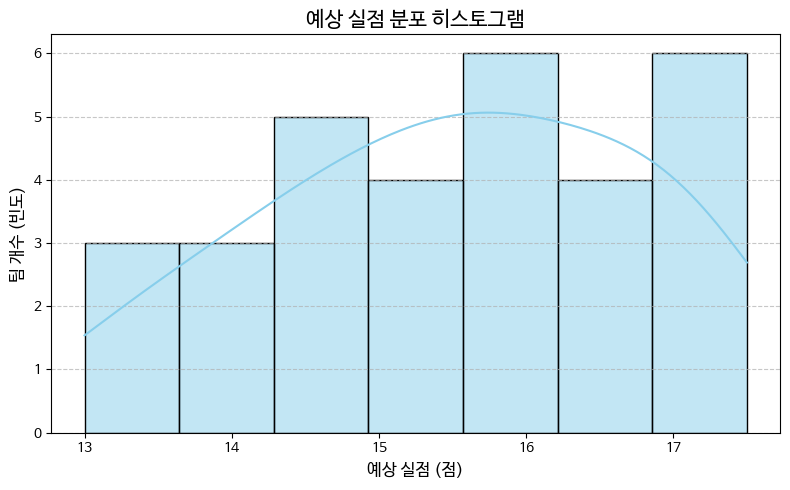

In [54]:
plt.figure(figsize=(8, 5))
sns.histplot(
    df_prediction['Predicted Score'],
    bins=7,
    kde=True,
    color='skyblue',
    edgecolor='black'
)

plt.title('예상 실점 분포 히스토그램', fontsize=15)
plt.xlabel('예상 실점 (점)', fontsize=12)
plt.ylabel('팀 개수 (빈도)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

예상 실점 상자 그림

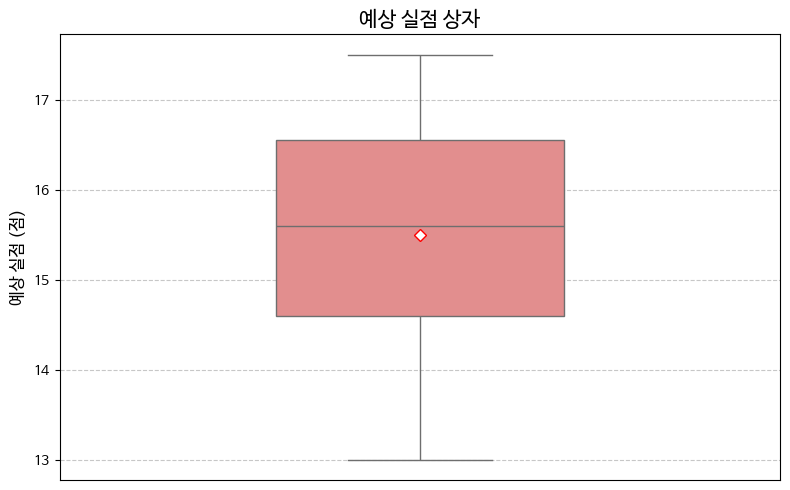

In [55]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    y=df_prediction['Predicted Score'],
    color='lightcoral',
    width=0.4,
    showmeans=True,meanprops={"marker":"D","markerfacecolor":"white", "markeredgecolor":"red"}
)

plt.title('예상 실점 상자', fontsize=15)
plt.ylabel('예상 실점 (점)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([])
plt.tight_layout()
plt.show()